In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.preprocessing import LabelEncoder

In [2]:
train_df = pd.read_csv('../Data/train.csv')

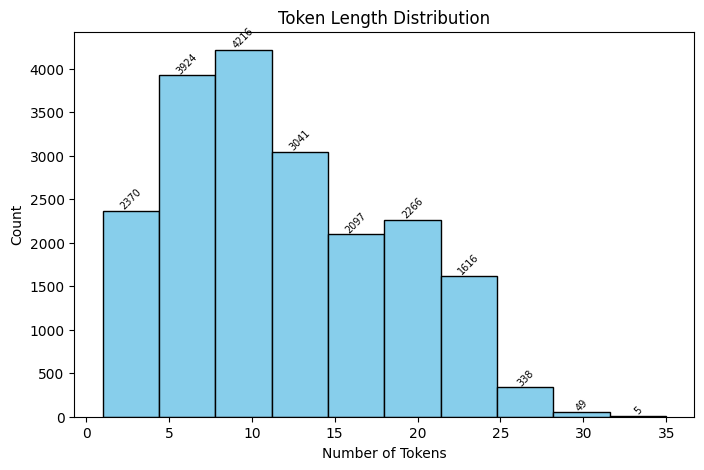

In [3]:
# Token length (for BERT), use:
train_df['token_length'] = train_df['text_cleaned'].astype(str).apply(lambda x: len(x.split()))
fig, ax = plt.subplots(figsize=(8, 5))
counts, bins, patches = ax.hist(train_df['token_length'], color='skyblue', edgecolor='black')
ax.set_title('Token Length Distribution')
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Count')

# Add value counts for the bins
for count, bin_left, bin_right in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        ax.text((bin_left + bin_right) / 2, count, str(int(count)),
                ha='center', va='bottom', fontsize=7, rotation=45)

plt.show()

## Variable Distributions

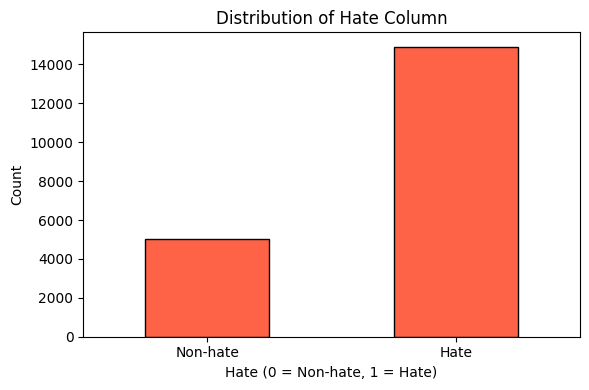

In [4]:
plt.figure(figsize=(6, 4))
train_df['hatespeech'].value_counts().sort_index().plot(
    kind='bar', color='tomato', edgecolor='black'
)
plt.title('Distribution of Hate Column')
plt.xlabel('Hate (0 = Non-hate, 1 = Hate)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-hate', 'Hate'], rotation=0)
plt.tight_layout()
plt.show()

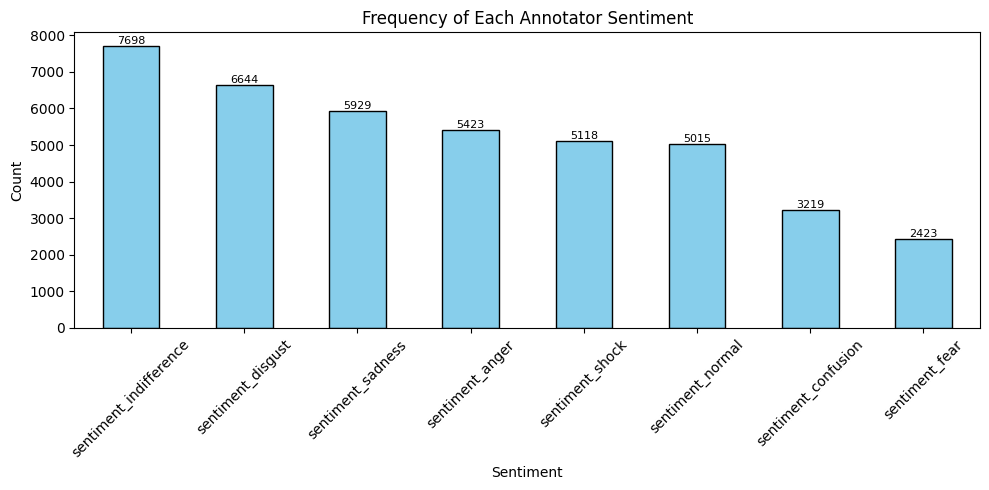

In [8]:
# List of sentiment columns
sentiment_cols = ['sentiment_indifference', 'sentiment_disgust', 'sentiment_sadness', 'sentiment_anger',
                    'sentiment_shock', 'sentiment_normal', 'sentiment_confusion', 'sentiment_fear']

# Sum each sentiment column to get counts
sentiment_counts = train_df[sentiment_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
ax = sentiment_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frequency of Each Annotator Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Add value counts on top of bars
for i, count in enumerate(sentiment_counts):
    ax.text(i, count, str(int(count)), ha='center', va='bottom', fontsize=8, rotation=0)

plt.show()

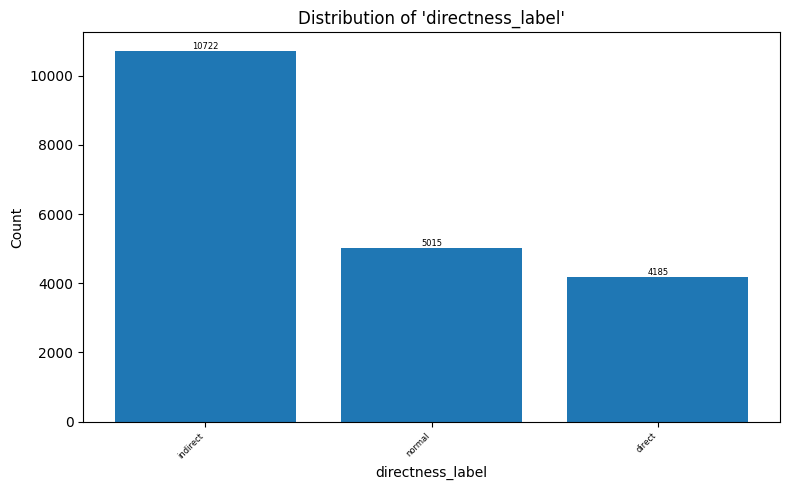

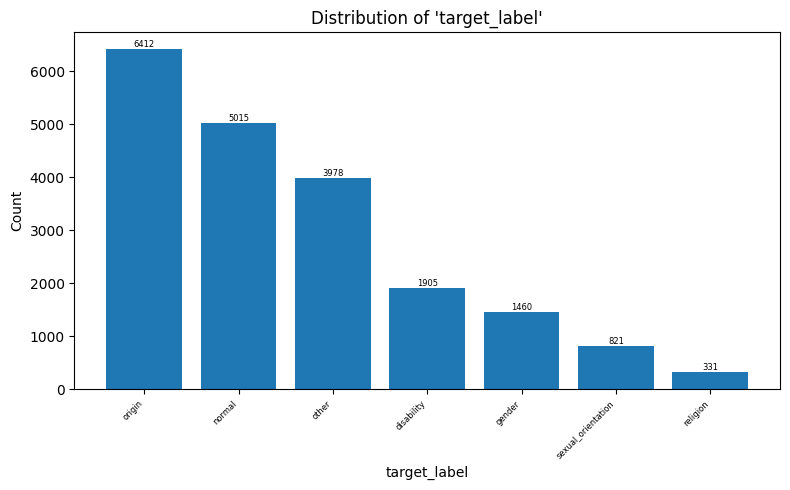

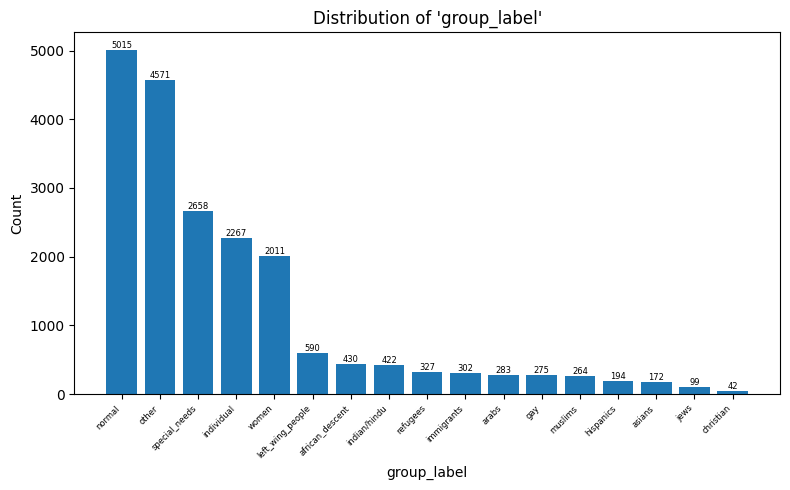

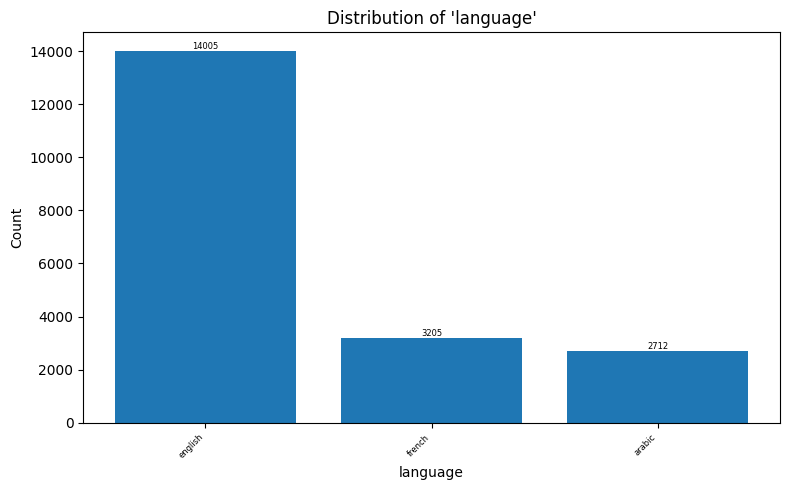

In [13]:
with open('../Data/label_maps.json', 'r') as f:
    label_maps = json.load(f)

def plot_distribution(column, label_map=None):
    value_counts = train_df[column].value_counts().sort_values(ascending=False)
    labels = value_counts.index.astype(str)
    if label_map:
        # Convert index to original labels if mapping provided
        labels = [label_map[str(idx)] if str(idx) in label_map else str(idx) for idx in value_counts.index]
    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, value_counts.values)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f"Distribution of '{column}'")
    plt.xticks(rotation=45, ha='right', fontsize=6)
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(int(bar.get_height())),
                 ha='center', va='bottom', fontsize=6)
    plt.tight_layout()
    plt.show()

plot_distribution('directness_label', label_maps['directness'])
plot_distribution('target_label', label_maps['target'])
plot_distribution('group_label', label_maps['group'])
plot_distribution('language')  # No mapping needed if already string

## Correlation and Co-occurrences

                        language_label  directness_label  target_label  \
language_label                1.000000         -0.133151      0.016242   
directness_label             -0.133151          1.000000     -0.279723   
target_label                  0.016242         -0.279723      1.000000   
group_label                  -0.253779          0.168070     -0.313010   
sentiment_indifference       -0.011645         -0.341007      0.152148   
sentiment_disgust            -0.062465         -0.234636      0.008683   
sentiment_sadness             0.142629         -0.268855      0.020322   
sentiment_anger               0.001409         -0.203165      0.029041   
sentiment_shock               0.017588         -0.278153      0.070947   
sentiment_normal             -0.026364          0.819500     -0.279972   
sentiment_confusion           0.047179         -0.135539      0.015577   
sentiment_fear                0.060659         -0.139913      0.003232   

                        group_label  

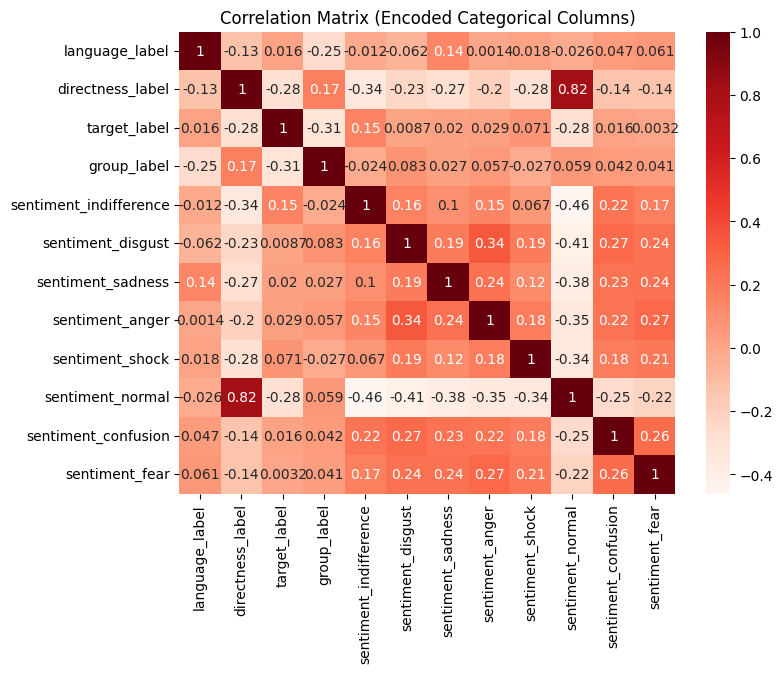

In [18]:
le = LabelEncoder()
train_df['language_label'] = le.fit_transform(train_df['language'].astype(str))

# Label encode the 5 categorical columns
categorical_cols = ['language_label', 'directness_label', 'target_label', 'group_label',
                    'sentiment_indifference', 'sentiment_disgust', 'sentiment_sadness', 'sentiment_anger',
                    'sentiment_shock', 'sentiment_normal', 'sentiment_confusion', 'sentiment_fear']

# Create a DataFrame with only the encoded columns
encoded_df = train_df[[col for col in categorical_cols]]

# Show correlation matrix for the encoded categorical columns
correlation_matrix = encoded_df.corr()
print(correlation_matrix)

# Optional: visualize the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds')
plt.title('Correlation Matrix (Encoded Categorical Columns)')
plt.show()


Language Cooccurrences


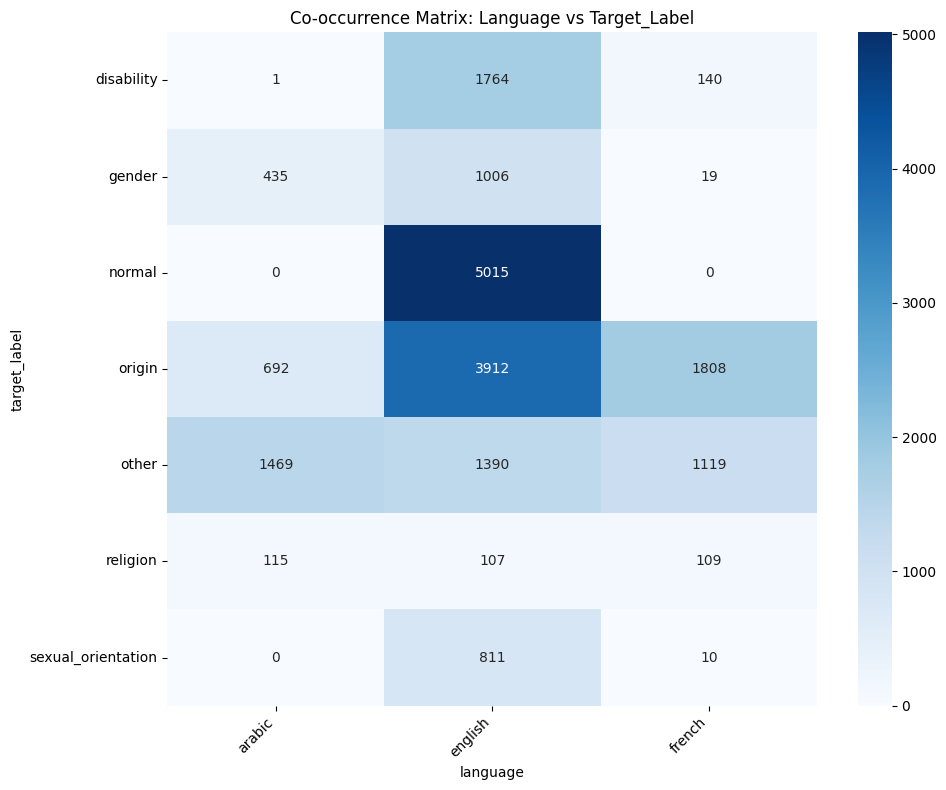

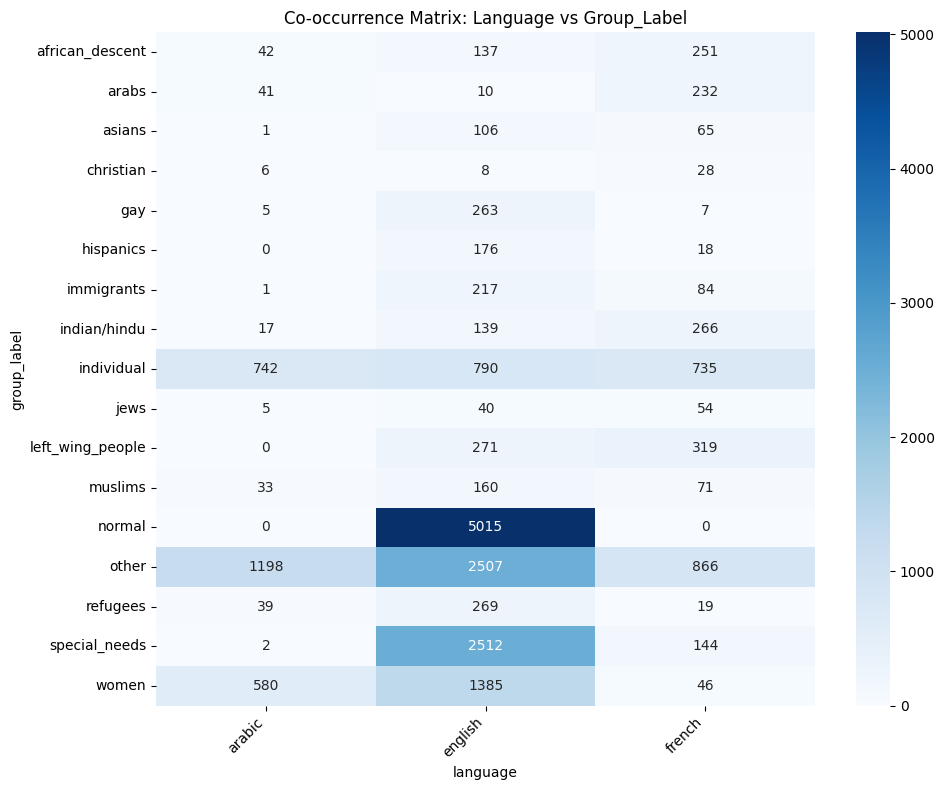


Directness Cooccurrences


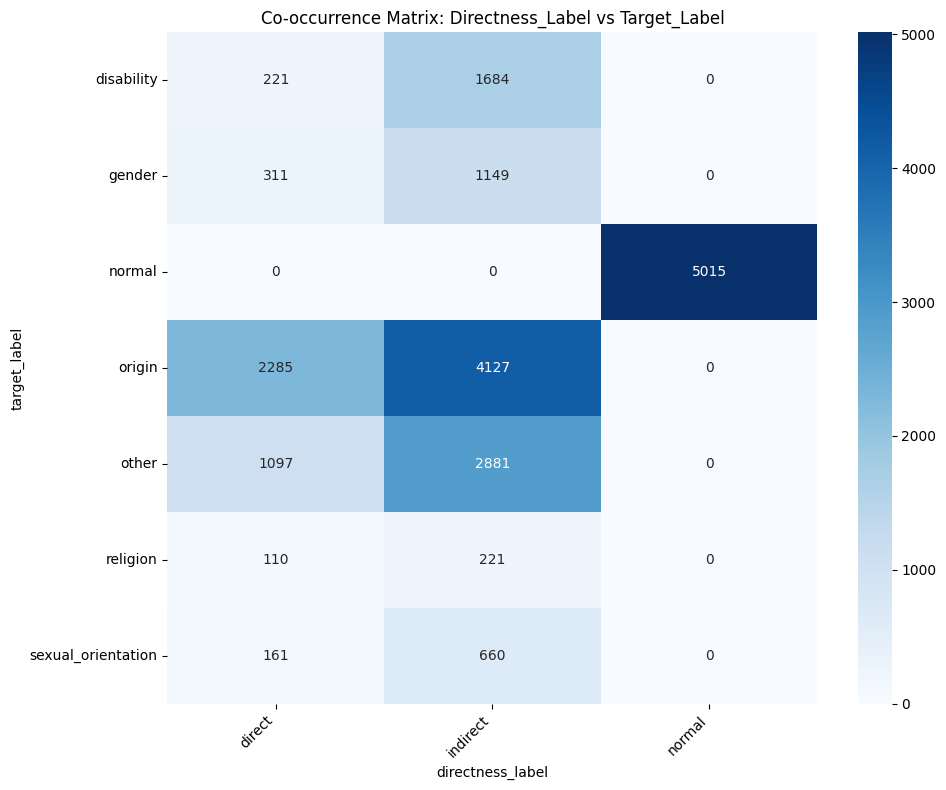

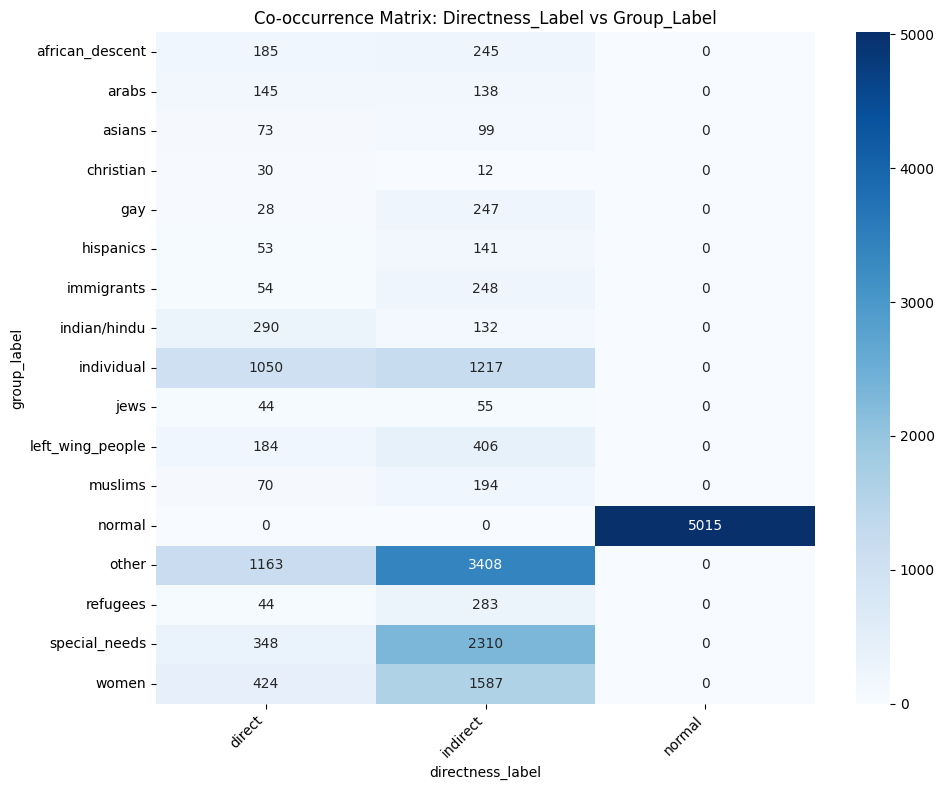

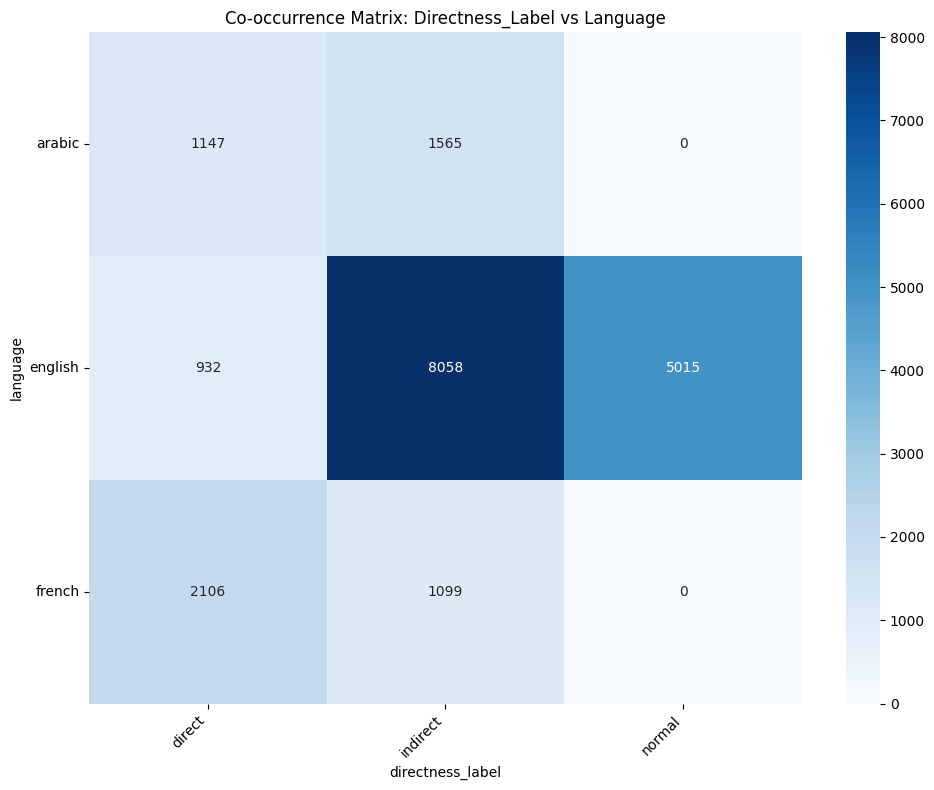


Group vs. Target


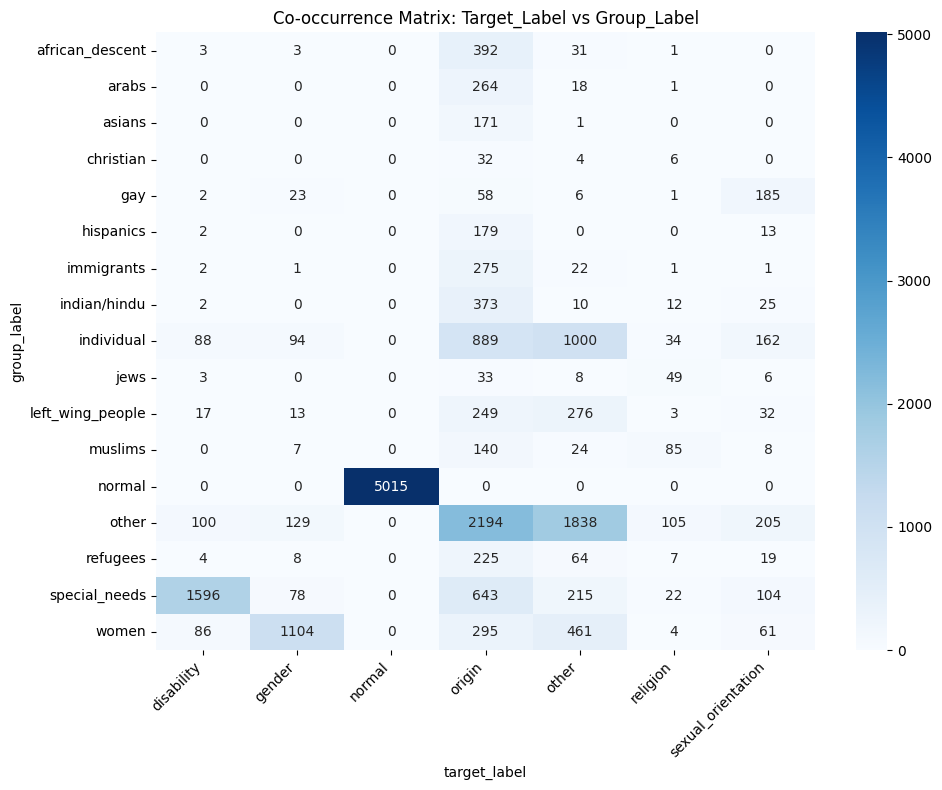

In [21]:
def decode_labels(values, label_map):
    # values: list or index of ints or strings
    # label_map: dict with string keys
    return [label_map.get(str(v), str(v)) for v in values]

def plot_cooccurrence_matrix(col1, col2, col1_name, col2_name, row_map=None, col_map=None):
    cooccurrence = pd.crosstab(
        train_df[col1_name], train_df[col2_name]
    ).reindex(index=col1, columns=col2, fill_value=0)
    # Decode row and column labels if mapping provided
    row_labels = decode_labels(cooccurrence.index, row_map) if row_map else cooccurrence.index.astype(str)
    col_labels = decode_labels(cooccurrence.columns, col_map) if col_map else cooccurrence.columns.astype(str)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cooccurrence, annot=True, fmt='d', cmap='Blues',
                xticklabels=col_labels, yticklabels=row_labels)
    plt.title(f'Co-occurrence Matrix: {col2_name.title()} vs {col1_name.title()}')
    plt.xlabel(col2_name)
    plt.ylabel(col1_name)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

directness = sorted(train_df['directness_label'].unique())
target = sorted(train_df['target_label'].unique())
group = sorted(train_df['group_label'].unique())
language = sorted(train_df['language'].unique())

print("\nLanguage Cooccurrences")
plot_cooccurrence_matrix(target, language, 'target_label', 'language',
                         row_map=label_maps['target'], col_map=None)
plot_cooccurrence_matrix(group, language, 'group_label', 'language',
                         row_map=label_maps['group'], col_map=None)
print("\nDirectness Cooccurrences")
plot_cooccurrence_matrix(target, directness, 'target_label', 'directness_label',
                         row_map=label_maps['target'], col_map=label_maps['directness'])
plot_cooccurrence_matrix(group, directness, 'group_label', 'directness_label',
                         row_map=label_maps['group'], col_map=label_maps['directness'])
plot_cooccurrence_matrix(language, directness, 'language', 'directness_label',
                         row_map=None, col_map=label_maps['directness'])
print("\nGroup vs. Target")
plot_cooccurrence_matrix(group, target, 'group_label', 'target_label',
                         row_map=label_maps['group'], col_map=label_maps['target'])

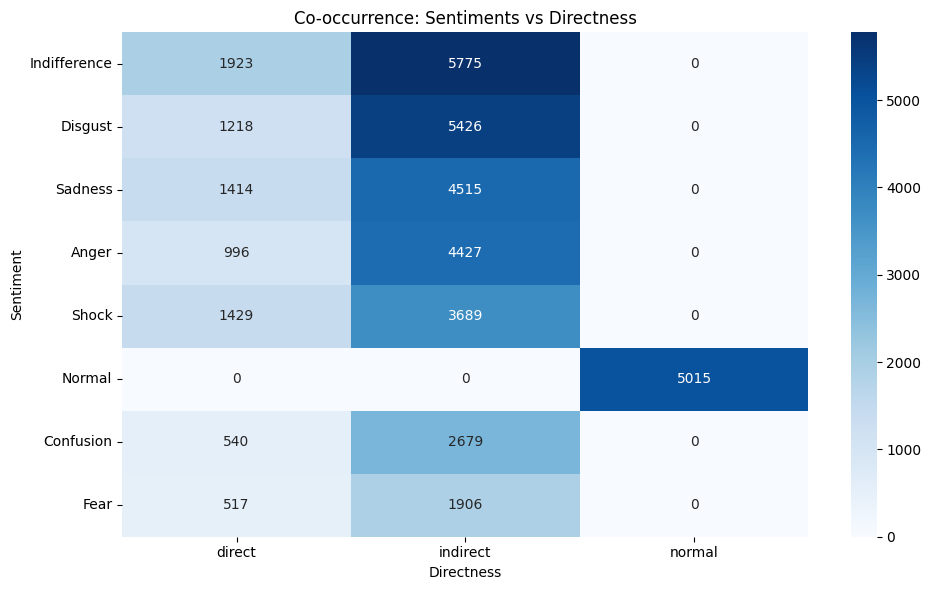

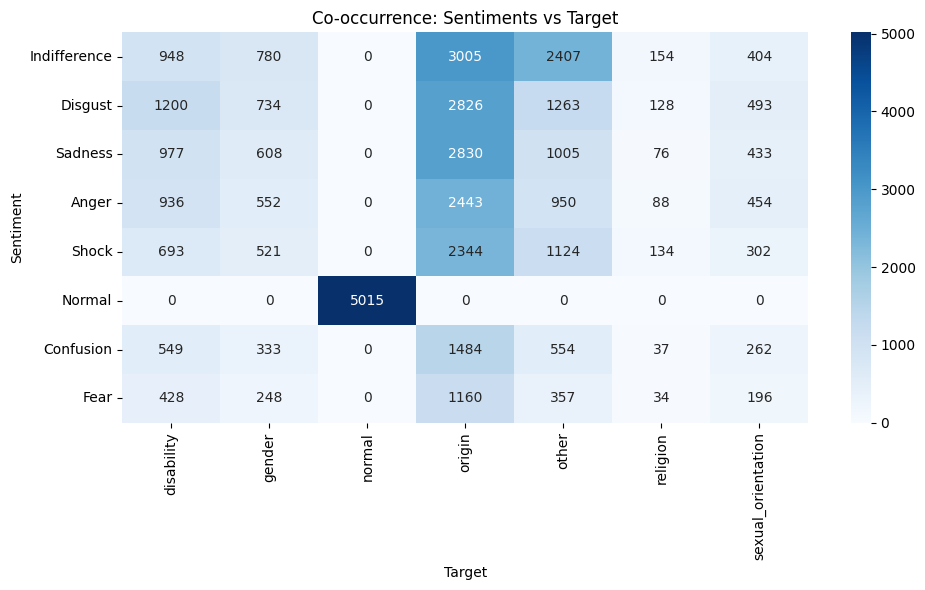

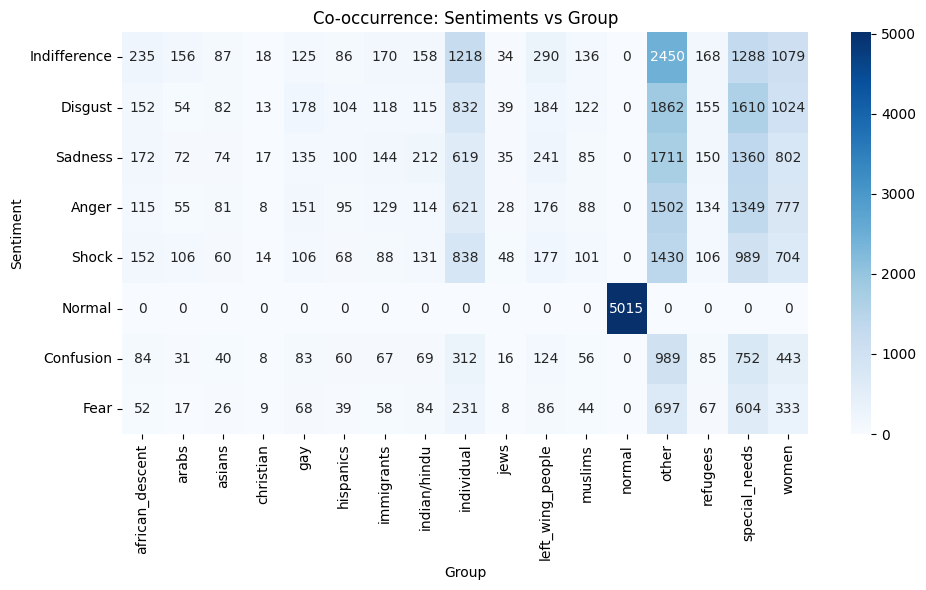

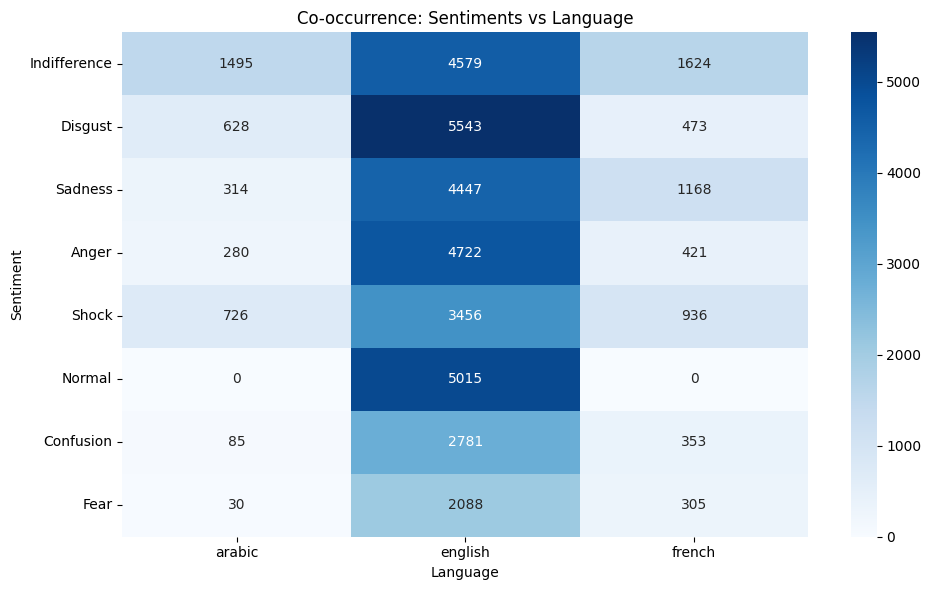

In [27]:
cooccurrence_targets = ['directness_label', 'target_label', 'group_label', 'language']

# Optionally, create a sentiment label map for pretty y-axis labels
sentiment_label_map = {col.replace('sentiment_', ''): col.replace('sentiment_', '').capitalize() for col in sentiment_cols}

for target_col in cooccurrence_targets:
    valid_sentiments = [col for col in sentiment_cols if col in train_df.columns]
    if not valid_sentiments:
        continue

    cooccurrence = pd.DataFrame(
        {sentiment.replace('sentiment_', ''): train_df.groupby(target_col)[sentiment].sum()
         for sentiment in valid_sentiments}
    ).T

    # Use label maps for x-axis (target_col)
    if target_col.replace('_label', '') in label_maps:
        label_map = label_maps[target_col.replace('_label', '')]
        col_labels = [label_map.get(str(idx), str(idx)) for idx in cooccurrence.columns]
    else:
        col_labels = cooccurrence.columns.astype(str)

    # Use sentiment label map for y-axis
    row_labels = [sentiment_label_map.get(idx, idx) for idx in cooccurrence.index]

    plt.figure(figsize=(10, 6))
    sns.heatmap(cooccurrence, annot=True, fmt='d', cmap='Blues',
                xticklabels=col_labels, yticklabels=row_labels)
    plt.title(f"Co-occurrence: Sentiments vs {target_col.replace('_label','').title()}")
    plt.xlabel(target_col.replace('_label','').title())
    plt.ylabel('Sentiment')
    plt.tight_layout()
    plt.show()

## Exploring Language Differences

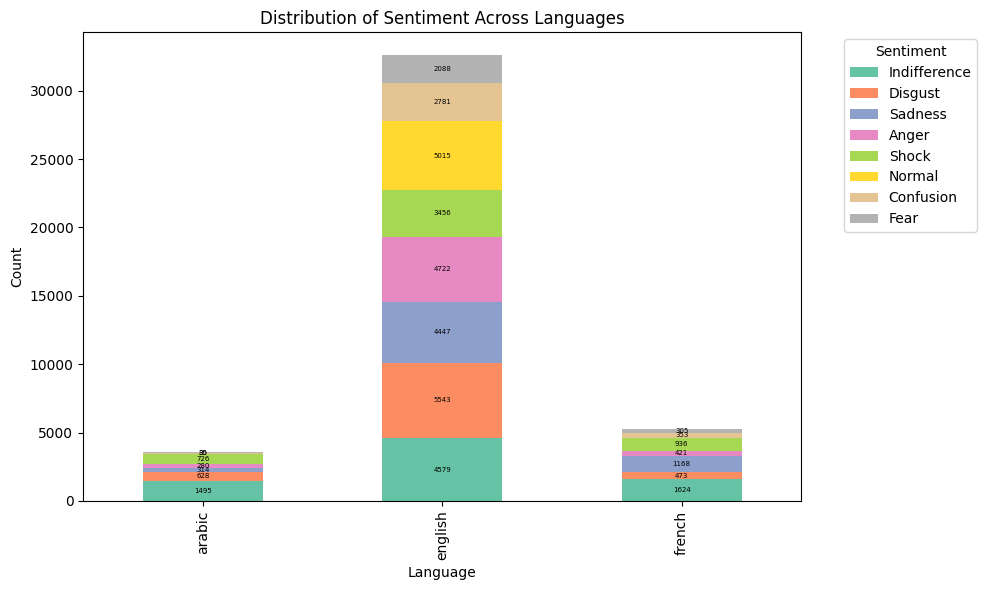

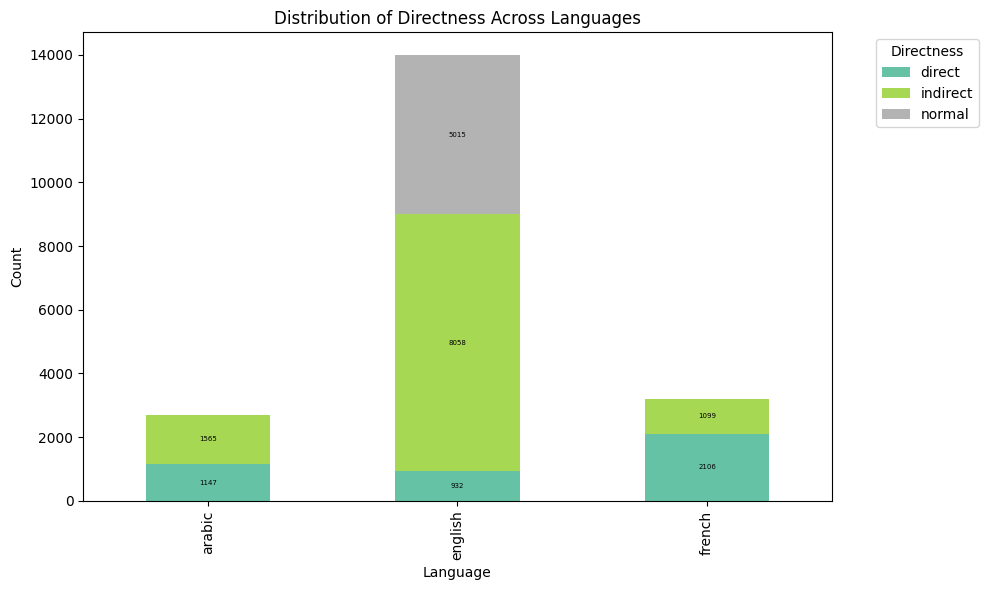

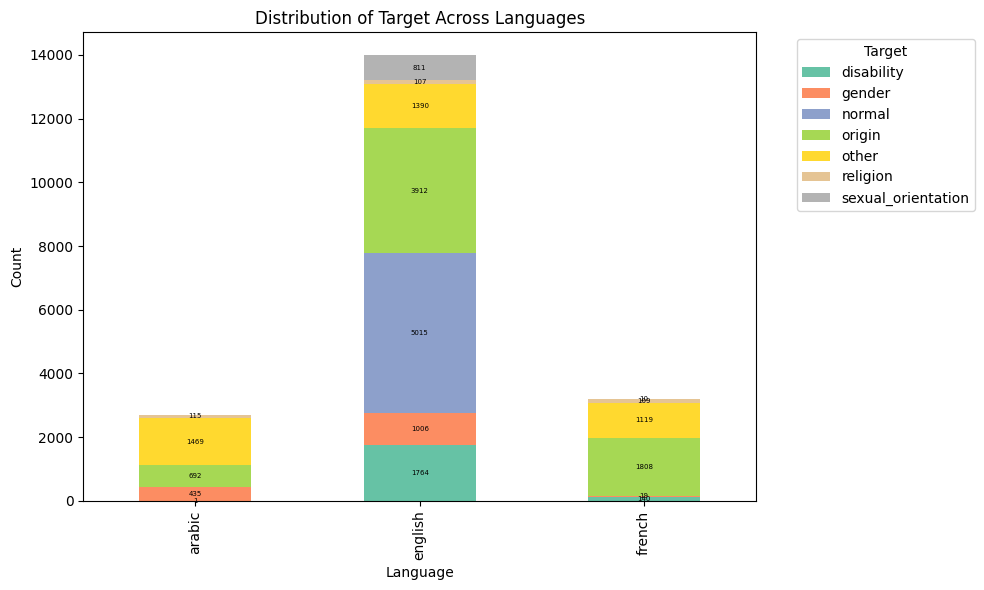

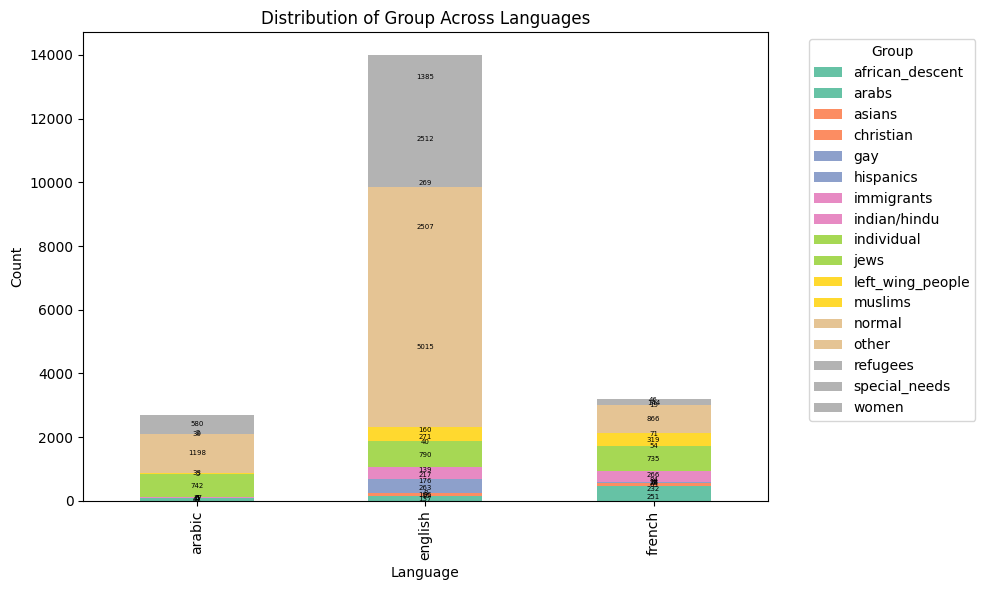

In [28]:
# Language vs. Label Distribution: Stacked Bar Plot (with label maps)
for label in ['sentiment', 'directness', 'target', 'group']:
    plt.figure(figsize=(10, 6))
    if label == 'sentiment':
        # Sentiment columns already have readable names
        lang_label_counts = train_df.groupby('language')[sentiment_cols].sum()
        legend_labels = [col.replace('sentiment_', '').capitalize() for col in sentiment_cols]
        lang_label_counts.columns = legend_labels
    else:
        label_col = f"{label}_label" if f"{label}_label" in train_df.columns else label
        lang_label_counts = pd.crosstab(train_df['language'], train_df[label_col])
        # Map legend labels if available
        if label in label_maps:
            legend_labels = [label_maps[label].get(str(idx), str(idx)) for idx in lang_label_counts.columns]
            lang_label_counts.columns = legend_labels
        else:
            legend_labels = lang_label_counts.columns.astype(str)
    ax = lang_label_counts.plot(kind='bar', stacked=True, colormap='Set2', figsize=(10,6), ax=plt.gca())
    plt.title(f'Distribution of {label.title()} Across Languages')
    plt.xlabel('Language')
    plt.ylabel('Count')
    plt.legend(title=label.title(), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # Add value counts on top of each bar segment
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax.annotate(f'{int(height)}',
                            (bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                            ha='center', va='center', fontsize=5, color='black')
    plt.show()

In [34]:
def show_samples_per_class_per_language(column, n=3):
    print(f"\nSample texts for each {column} per language:")
    for lang in train_df['language'].dropna().unique():
        print(f"\n=== Language: {lang} ===")
        if column == 'sentiment':
            for sentiment_col in sentiment_cols:
                sentiment_key = sentiment_col.replace('sentiment_', '')
                sentiment_name = sentiment_key.capitalize()
                print(f"\n--- Sentiment: {sentiment_name} ---")
                samples = train_df[(train_df['language'] == lang) & (train_df[sentiment_col] == 1)]['text_cleaned'].dropna().head(n)
                if samples.empty:
                    print("No samples available.")
                else:
                    for i, text in enumerate(samples, 1):
                        print(f"{i}. {text}")
        else:
            # Use label map if available
            label_key = column.replace('_label', '')
            label_map = label_maps.get(label_key, {})
            classes = train_df[column].dropna().unique()
            for cls in classes:
                class_name = label_map.get(str(cls), str(cls))
                print(f"\n--- {column.title()}: {class_name} ---")
                samples = train_df[(train_df['language'] == lang) & (train_df[column] == cls)]['text_cleaned'].dropna().head(n)
                if samples.empty:
                    print("No samples available.")
                else:
                    for i, text in enumerate(samples, 1):
                        print(f"{i}. {text}")

In [35]:
show_samples_per_class_per_language('directness_label', n=3)  


Sample texts for each directness_label per language:

=== Language: french ===

--- Directness_Label: indirect ---
1. qui connaissait ce militant de la cause animale esteban qui tué en se défendant un jeune gauchiste no…
2. surtout les noirs et les arabes au pire ils auront leur entretien mais qd le mec verra leur tête à ce m…
3. ce qui n'as rien voir avec le fait d'etre en haut de l'echelle alimentaire ou no...

--- Directness_Label: normal ---
No samples available.

--- Directness_Label: direct ---
1. t’etais pas à ivry avec un renois tout à l’heure ? — dans la cave la ?
2. après rouler en agglo à 80 et prendre les giratoire en 4e les rebeus nous montrent comment freiner avec le putain d…
3. j’aurais aimé le voir se fr lyncher pr de vrai les arabes et les noirs ca comptes pr du beurres mais…

=== Language: english ===

--- Directness_Label: indirect ---
1. dads twat look like him. break homes well prick.
2. He probably only hates the shithole countries (as defined by him). We know t

In [37]:
show_samples_per_class_per_language('target_label', n=3)  


Sample texts for each target_label per language:

=== Language: french ===

--- Target_Label: other ---
1. qui connaissait ce militant de la cause animale esteban qui tué en se défendant un jeune gauchiste no…
2. ce qui n'as rien voir avec le fait d'etre en haut de l'echelle alimentaire ou no...
3. lui est un gros mongol du point de vue l'intelligence.

--- Target_Label: origin ---
1. surtout les noirs et les arabes au pire ils auront leur entretien mais qd le mec verra leur tête à ce m…
2. t’etais pas à ivry avec un renois tout à l’heure ? — dans la cave la ?
3. après rouler en agglo à 80 et prendre les giratoire en 4e les rebeus nous montrent comment freiner avec le putain d…

--- Target_Label: normal ---
No samples available.

--- Target_Label: disability ---
1. tavais qua pas te faire voler mongol
2. vous êtes mongol un championnat c'est pas en 1 match ; et au bar…
3. j'suis un ptn de mongol

--- Target_Label: gender ---
1. les féministes extrémistes sont cancer en effet. mais la 

In [38]:
show_samples_per_class_per_language('group_label', n=3)  


Sample texts for each group_label per language:

=== Language: french ===

--- Group_Label: individual ---
1. qui connaissait ce militant de la cause animale esteban qui tué en se défendant un jeune gauchiste no…
2. lui est un gros mongol du point de vue l'intelligence.
3. après rouler en agglo à 80 et prendre les giratoire en 4e les rebeus nous montrent comment freiner avec le putain d…

--- Group_Label: african_descent ---
1. surtout les noirs et les arabes au pire ils auront leur entretien mais qd le mec verra leur tête à ce m…
2. j’aurais aimé le voir se fr lyncher pr de vrai les arabes et les noirs ca comptes pr du beurres mais…
3. des noirs au milieu des rebeus pour la technique c’est mon lyon ça

--- Group_Label: normal ---
No samples available.

--- Group_Label: other ---
1. ce qui n'as rien voir avec le fait d'etre en haut de l'echelle alimentaire ou no...
2. t’etais pas à ivry avec un renois tout à l’heure ? — dans la cave la ?
3. les rebeus ils kiffent les samsungs en génér

In [36]:
show_samples_per_class_per_language('sentiment', n=3)  


Sample texts for each sentiment per language:

=== Language: french ===

--- Sentiment: Indifference ---
1. surtout les noirs et les arabes au pire ils auront leur entretien mais qd le mec verra leur tête à ce m…
2. ce qui n'as rien voir avec le fait d'etre en haut de l'echelle alimentaire ou no...
3. t’etais pas à ivry avec un renois tout à l’heure ? — dans la cave la ?

--- Sentiment: Disgust ---
1. surtout les noirs et les arabes au pire ils auront leur entretien mais qd le mec verra leur tête à ce m…
2. j’aurais aimé le voir se fr lyncher pr de vrai les arabes et les noirs ca comptes pr du beurres mais…
3. voilà que ça triche sale arabe

--- Sentiment: Sadness ---
1. t’etais pas à ivry avec un renois tout à l’heure ? — dans la cave la ?
2. après rouler en agglo à 80 et prendre les giratoire en 4e les rebeus nous montrent comment freiner avec le putain d…
3. j’aurais aimé le voir se fr lyncher pr de vrai les arabes et les noirs ca comptes pr du beurres mais…

--- Sentiment: Anger -